# Credit Card Default Prediction
Course Project of ISOM 3360, Spring 2020

Group 21

In [1]:
# Import basic libraries
# import numpy as np 
import pandas as pd

In [2]:
# Load the data
data = pd.read_csv('data.csv',index_col = 'ID')


## Variables
There are 25 variables:

- ID: ID of each client
- LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit)
- SEX: Gender (1=male, 2=female)
- EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- MARRIAGE: Marital status (1=married, 2=single, 3=others)
- AGE: Age in years
- PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
- PAY_2: Repayment status in August, 2005 (scale same as above)
- PAY_3: Repayment status in July, 2005 (scale same as above)
- PAY_4: Repayment status in June, 2005 (scale same as above)
- PAY_5: Repayment status in May, 2005 (scale same as above)
- PAY_6: Repayment status in April, 2005 (scale same as above)
- BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
- BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
- BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
- BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
- BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
- BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
- PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
- PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
- PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
- PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
- PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
- PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
- default.payment.next.month: Default payment (1=yes, 0=no)


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   30000 non-null  float64
 1   SEX                         30000 non-null  int64  
 2   EDUCATION                   30000 non-null  int64  
 3   MARRIAGE                    30000 non-null  int64  
 4   AGE                         30000 non-null  int64  
 5   PAY_0                       30000 non-null  int64  
 6   PAY_2                       30000 non-null  int64  
 7   PAY_3                       30000 non-null  int64  
 8   PAY_4                       30000 non-null  int64  
 9   PAY_5                       30000 non-null  int64  
 10  PAY_6                       30000 non-null  int64  
 11  BILL_AMT1                   30000 non-null  float64
 12  BILL_AMT2                   30000 non-null  float64
 13  BILL_AMT3                   300

## Data Cleaning
- No missing values, but there are a few anomalous things
- Variable name:
    1. PAY_0 is very confusing, should be changed to PAY_1 in consistensy with other variable names
    2. Change target variable name from 'default.pay.next.month' to 'def_pay'
- Understand categorical and numerical data respectively


In [4]:
# Change variable name
data = data.rename(columns={'default.payment.next.month': 'def_pay', 'PAY_0': 'PAY_1'})

In [5]:
# To have a general idea of the default probability
data['def_pay'].value_counts()[1] / data.shape[0]

0.2212

In [6]:
# Categorical variables
data['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [7]:
data['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

EDUCATION has category 5 and 6 that both are 'unknown', and a label 0 that is undocumented.

In [8]:
# The 0 (undocumented label), 5 and 6 ('unknown' label) in EDUCATION can also be put in a 'Other' (thus 4)
data['EDUCATION'].replace([0, 5, 6], 4, inplace=True)

data['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [9]:
data['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

MARRIAGE has a label 0 that is undocumented.

In [10]:
# The 0 in MARRIAGE can be safely categorized as 'Other' (thus 3)
data['MARRIAGE'].replace(0, 3, inplace=True) 
data['MARRIAGE'].value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

One might wonder what these labels might mean something.

"Other" in education can be education lower than the high school level.

"Other" in marriage could be, for example, "divorced". 


## Data visualization

In [11]:
# import libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

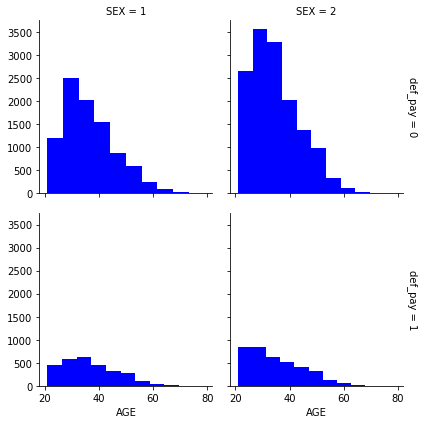

In [12]:
# histogram for categorical variables
g = sns.FacetGrid(data, col='SEX', row='def_pay', margin_titles=True)
g.map(plt.hist,'AGE',color='blue')

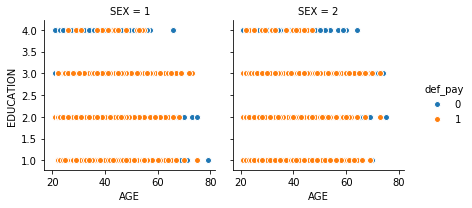

In [13]:
g = sns.FacetGrid(data, hue='def_pay', col='SEX', margin_titles=True)
g=g.map(plt.scatter, 'AGE', 'EDUCATION',edgecolor='w').add_legend()

In [14]:
repayments = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
bill_amounts = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
payments = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [15]:
# histogram for numerical variables
# Payment delay
data[repayments].describe()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100
std,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


PAY_X has labels -2 and -1 that are undocumented. If 1,2,3, etc are the months of delay and 0 is labeled as 'pay duly', then any negative value should be seen as 0.

In [16]:
data[repayments] = data[payments].clip(lower=0)
data[repayments].describe()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029DEA4FF7B8>,
      dtype=object)

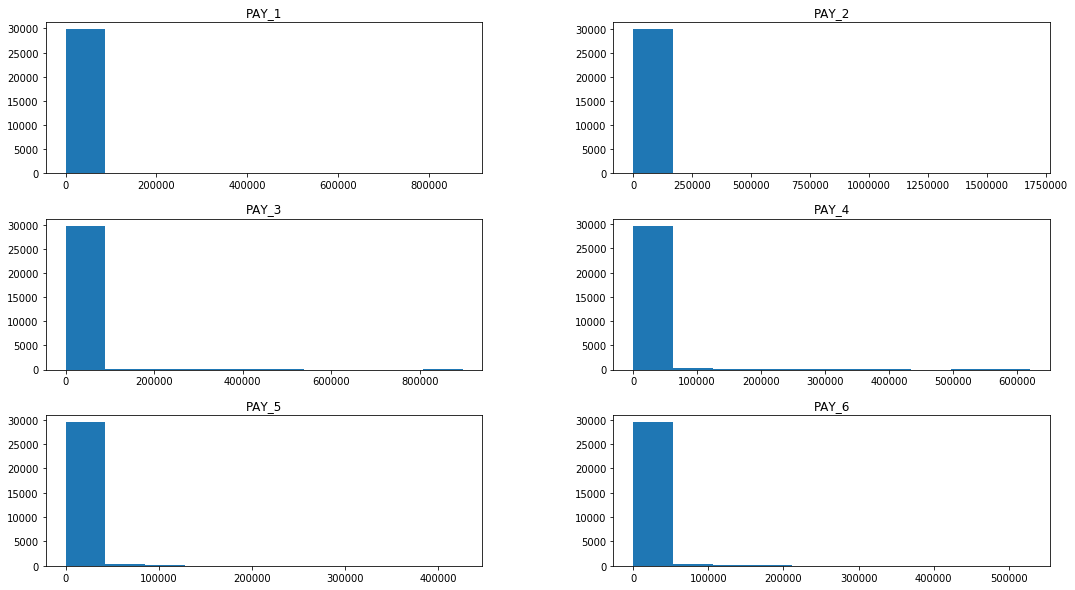

In [17]:
data[repayments].hist(bins=10, figsize=(18,10), grid=False)

In [18]:
# Bill statement 
data[bill_amounts].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029DDFDB76D8>,
      dtype=object)

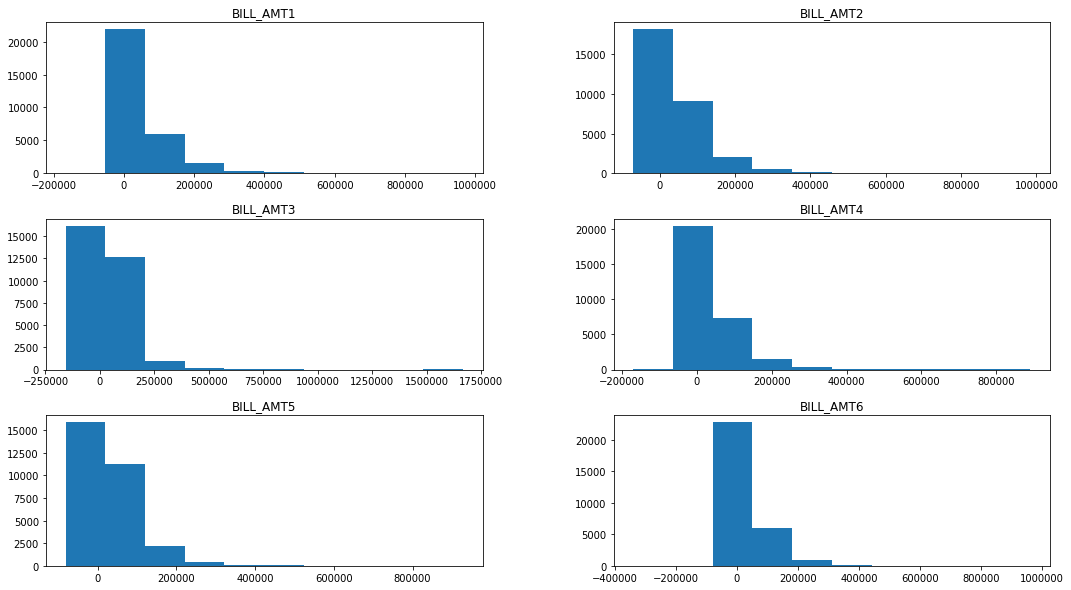

In [19]:
data[bill_amounts].hist(bins=10, figsize=(18,10), grid=False)

Negative values of bill statement can be interpreted as credit? 

In [20]:
#Previous payment
data[payments].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029DEA5E4CF8>,
      dtype=object)

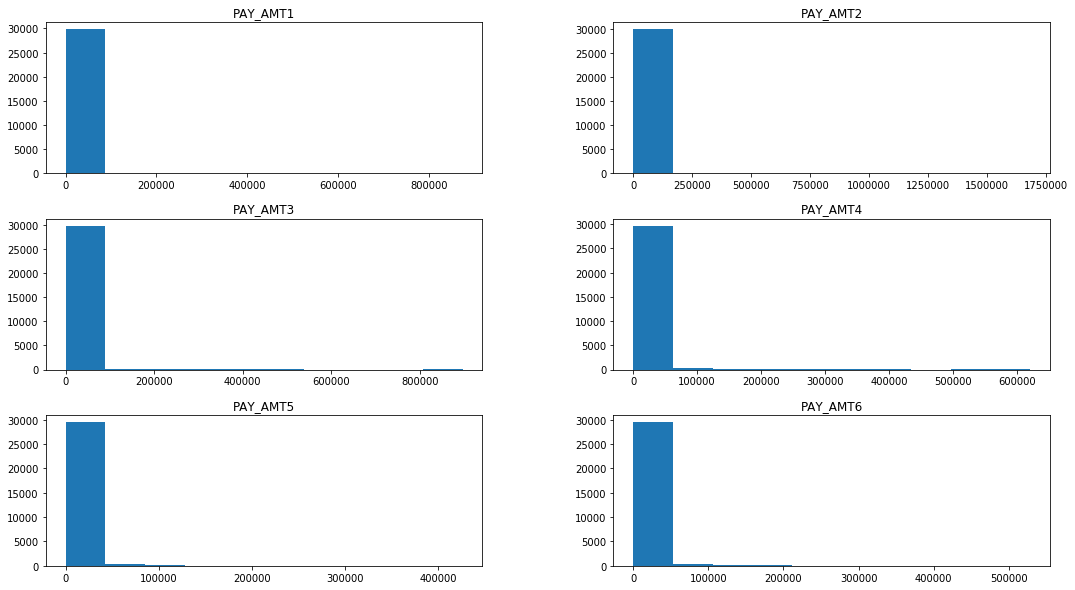

In [21]:
data[payments].hist(bins=10,figsize=(18,10),grid=False)

In [22]:
data['LIMIT_BAL'].describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

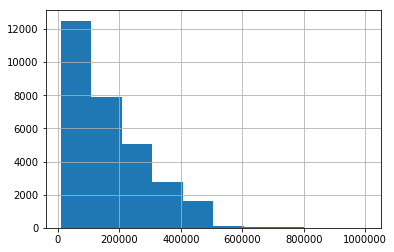

In [23]:
data['LIMIT_BAL'].hist()

The range is very broad. Will cluster the data in a narrower range.

In [24]:
data['AGE'].describe()

count    30000.000000
mean        35.485500
std          9.217904
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

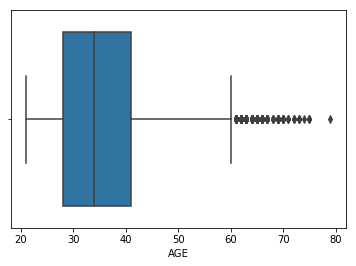

In [25]:
# boxplot for AGE 
ax = sns.boxplot(data['AGE'])

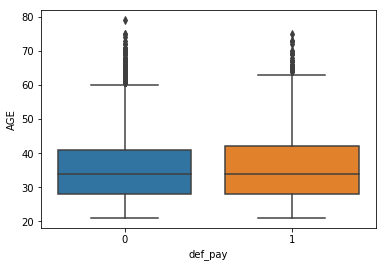

In [26]:
# boxplot for AGE regarding Default
bx = sns.boxplot(x = data['def_pay'], y = data['AGE'])

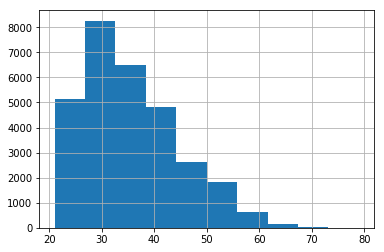

In [27]:
# histogram for Age
data['AGE'].hist()

## Decision Tree Model

In [28]:
# import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

In [29]:
# define independent variables / attirbutes / features
features = ['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE'] + repayments + bill_amounts + payments
# define one single target variable / label
target = ['def_pay']

In [30]:
# get defined training dataset
X = data[features]
y = data[target]

In [31]:
# build a decision tree model with the defalut hyperparameter settings
DTM_0 = DecisionTreeClassifier()
DTM_0.fit(X,y)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [33]:
DTM_0.get_depth()

45

In [34]:
DTM_0.get_n_leaves()

5079

### Cross Validation

In [35]:
# import evaluation tools
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [36]:
# import cross validation
from sklearn.model_selection import cross_val_score, GridSearchCV

In [38]:
score_cv = cross_val_score(DTM_0, X, y, cv=10)

In [39]:
score_cv.mean()

0.6974666666666666

In [40]:
# define the numbers to try out for depth and max number of leaf nodes 
depths = list(range(5, 45, 5))
num_leafs = list(range(500, 6000, 500))

In [41]:
param_grid = [{'max_depth':depths,
              'max_leaf_nodes':num_leafs}]

In [42]:
# define Model using GridSearchCV
DTM = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=10)

In [43]:
DTM.fit(X,y)

KeyboardInterrupt: 

In [ ]:
# find the best parameters
DTM.best_params_

In [ ]:
DTM.best_score_

In [ ]:
my_model = DecisionTreeClassifier(max_leaf_nodes = 500, max_depth = 5)

In [ ]:
my_model.fit(x,y)

In [ ]:
DTM_pred = my_model.predict(x)

## Logistics Regression Model

In [ ]:
from sklearn import preprocessing

In [ ]:
# Normalize attributes
zscore_scaler = preprocessing.StandardScaler().fit(x)
X_transform = pd.DataFrame(zscore_scaler.transform(x), columns = x.columns)

In [ ]:
x.head()

In [ ]:
X_transform.head()

In [ ]:
# import Logistic Regression from sklearn
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(penalty='l1', C=1.0, random_state=0, solver='saga')

In [ ]:
lr

In [ ]:
# change target column to array
yact = y.values.ravel()

In [ ]:
score_cv2 = cross_val_score(lr, X_transform, yact, cv=10)

In [ ]:
# accuracy from cross validation
score_cv2

In [ ]:
score_cv2.mean()

In [ ]:
#predict value of target based on cross validation
LR_pred = cross_val_predict(lr, X_transform, yact, cv=10)

## Model Evaluation

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import matplotlib as mpl
import matplotlib.pyplot as plt

### Decision tree

In [ ]:
# Confusion matrix
print("Confusion Matrix:", '\n',confusion_matrix(y, DTM_pred))
print("Accuracy:",accuracy_score(y, DTM_pred, normalize=True, sample_weight=None))

In [ ]:
print(classification_report(y, DTM_pred))

### Logistics regression

In [ ]:
# Confusion matrix
print("Confusion Matrix:", '\n',confusion_matrix(y, LR_pred))
print("Accuracy:",accuracy_score(y, LR_pred, normalize=True, sample_weight=None))

In [ ]:
print(classification_report(y, LR_pred))